Shape of the dataframe: (43824, 13)


C:\ca_da\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Shape of train: (35064, 15)
Shape of test: (8760, 15)
Shape of train arrays: (35057, 7) (35057,)
[0.54545455 0.52727273 0.50909091 0.50909091 0.49090909 0.47272727
 0.47272727]
0.47272727272727266
Shape of Test arrays: (8753, 7) (8753,)
[0.41818182 0.4        0.4        0.4        0.38181818 0.38181818
 0.38181818]
0.40000000000000213
Shape of arrays after reshaping: (35057, 7, 1) (8753, 7, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7, 64)             256       
_________________________________________________________________
average_pooling1d (AveragePo (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dropout (Dropout)            (None, 320)               

Text(0.5, 0, 'Index')

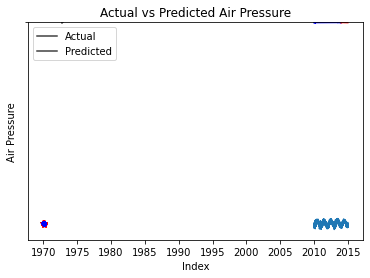

In [2]:
# -*- coding: utf-8 -*-
"""

Air pollution PRES prediction by CNN
@author: kjw
"""

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime


#Read the dataset into a pandas.DataFrame
df = pd.read_csv('C:\study\workspace_python\pdsample\datasets\mydata\PRSA_data_2010.1.1-2014.12.31.csv')
print('Shape of the dataframe:', df.shape)
df.head()

# Index creation
df['datetime'] = df[['year', 'month', 'day', 'hour']].\
    apply(lambda row: datetime.datetime(year=row['year'], \
    month=row['month'], day=row['day'],hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)
df.head()

#Let us draw a box plot to visualize the central tendency and dispersion of PRES
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

# Time series visualization
g = sns.lineplot(x='datetime',y='PRES',data=df)
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure readings in hPa')


# Minmax scaling PRES variable
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))
df.head()

"""
Let's start by splitting the dataset into train and test. 
The dataset's time period is from
Jan 1st, 2010 to Dec 31st, 2014. 
The first four years - 2010 to 2013 is used as train and
2014 is kept for test.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_test = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_test.shape)


#First five rows of train
df_train.head()

#First five rows of test
df_test.head()

#Reset the indices of the validation set
df_test.reset_index(drop=True, inplace=True)
df_test.head()

"""
The train and test time series of standardized PRES are also plotted.
"""

g = sns.lineplot(x='datetime',y='scaled_PRES',data=df_train, color='b')
g.set_title('Time series of scaled Air Pressure in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

g = sns.lineplot(x='datetime',y='scaled_PRES',data=df_test, color='r')
g.set_title('Time series of scaled Air Pressure in test set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

# Make dataset to forecast using past 7 days

def makeXy(ts, nb_timesteps):
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

# Make training set
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)
print(X_train[0])
print(y_train[0])

# Make test set
X_test, y_test = makeXy(df_test['scaled_PRES'], 7)
print('Shape of Test arrays:', X_test.shape, y_test.shape)
print(X_test[0])
print(y_test[0])

# Keras import
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.models import Sequential

#X_train and X_val are reshaped to 3D arrays
X_train, X_test = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),\
                 X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_test.shape)

model=Sequential()
model.add(Conv1D(64, 3, strides=1, use_bias=True, input_shape=(7,1),padding='same'))
model.add(AveragePooling1D(pool_size=3, strides=1))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

history=model.fit(X_train, y_train, batch_size=16, epochs=10,shuffle=True)

preds = model.predict(X_test)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

# R2 Calculation
from sklearn.metrics import r2_score
r2 = r2_score(df_test['PRES'].loc[7:], pred_PRES)
print('R-squared for the test set:', round(r2,4))

#Let's plot the first 50 actual and predicted values of air pressure.
plt.plot(range(50), df_test['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

